In [1]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle
import os

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Utility
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# PREPROCESSING FUNCTION
def preprocess_text(text):
    """
    Unified preprocessing function untuk semua model
    Digunakan saat training dan inference

    Args:
        text: String input

    Returns:
        cleaned_text: String yang sudah dibersihkan
    """
    if pd.isna(text) or text is None:
        return ""

    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove repeated characters (more than 2)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Remove special characters (keep Indonesian letters, spaces, !, ?)
    text = re.sub(r'[^a-zA-Z\s!?]', ' ', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [3]:
# LOAD DATA

df = pd.read_csv("youtube_komentar_labeled.csv")

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")


Dataset loaded successfully!
Shape: (6444, 6)

Columns: ['author', 'text', 'published_at', 'like_count', 'clean_text', 'label_sentimen']


In [4]:
# EXPLORATORY DATA ANALYSIS (EDA)

# Basic info
print("\n Dataset Info:")
print(df.info())

print("\n First 5 rows:")
print(df.head())

# Check missing values
print("\n Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values")

# Check duplicates
print("\n Duplicate Check:")
duplicates = df.duplicated(subset='text').sum()
print(f"Number of duplicates: {duplicates}")

if duplicates > 0:
    print("Removing duplicates...")
    df = df.drop_duplicates(subset='text')
    df = df.reset_index(drop=True)
    print(f"Shape after removing duplicates: {df.shape}")


 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6444 entries, 0 to 6443
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   author          6440 non-null   object
 1   text            6444 non-null   object
 2   published_at    6444 non-null   object
 3   like_count      6444 non-null   int64 
 4   clean_text      6444 non-null   object
 5   label_sentimen  6444 non-null   object
dtypes: int64(1), object(5)
memory usage: 302.2+ KB
None

 First 5 rows:
             author                                               text  \
0  @jokonawanto1844  Berimbang dan netral.. cerdas dan bijak dalam ...   
1      @MaksumEncum  Jangan. Menyalah2 keumat Islam. Indonesia. Bak...   
2      @SubaNus-e8r  TIDAK,,\nSEMUA AGAMA ADALAH SAMA TAK ADA PEMBE...   
3   @sabriishak2788  Saya harap kritikan kang guru kpd KDM di ambil...   
4  @IGEDERAUH-ok2ct  Gr gembul mg sll di berikan keselamatan unt tr...   

        

In [5]:
# TEXT PREPROCESSING

# Apply preprocessing
print("\nApplying  preprocessing function...")
df['clean_text'] = df['text'].apply(preprocess_text)

# Show examples
print("\nExample of cleaned text:")
for i in range(3):
    print(f"\n{i+1}. Original: {df['text'].iloc[i][:80]}...")
    print(f"   Cleaned:  {df['clean_text'].iloc[i][:80]}...")

# Remove empty texts
initial_count = len(df)
df = df[df['clean_text'].str.strip() != '']
df = df.reset_index(drop=True)
removed = initial_count - len(df)

if removed > 0:
    print(f"\nRemoved {removed} empty texts")
    print(f"   Final shape: {df.shape}")

# Text statistics
df['text_length'] = df['clean_text'].str.len()
df['word_count'] = df['clean_text'].str.split().str.len()

print("\n Text Length Statistics:")
print(df['text_length'].describe())

print("\n Word Count Statistics:")
print(df['word_count'].describe())

# Calculate recommended MAX_LEN
percentile_95 = int(df['word_count'].quantile(0.95))
percentile_99 = int(df['word_count'].quantile(0.99))

print(f"\nRecommended MAX_LEN:")
print(f"  95th percentile: {percentile_95} words")
print(f"  99th percentile: {percentile_99} words")
print(f"  Recommended for Bi-LSTM: {percentile_95}")
print(f"  Recommended for BERT/Hybrid: 128 (BERT standard)")


Applying  preprocessing function...

Example of cleaned text:

1. Original: Berimbang dan netral.. cerdas dan bijak dalam menyampaikan pendapatnya... Guru g...
   Cleaned:  berimbang dan netral cerdas dan bijak dalam menyampaikan pendapatnya guru gembul...

2. Original: Jangan. Menyalah2 keumat Islam. Indonesia. Bakal Bubar...
   Cleaned:  jangan menyalah keumat islam indonesia bakal bubar...

3. Original: TIDAK,,
SEMUA AGAMA ADALAH SAMA TAK ADA PEMBEDA YG MEMBEDAKAN MANUSIA HANYA TING...
   Cleaned:  tidak semua agama adalah sama tak ada pembeda yg membedakan manusia hanya tingka...

 Text Length Statistics:
count    6444.000000
mean      150.065177
std       224.809917
min         1.000000
25%        47.000000
50%        91.000000
75%       174.000000
max      5371.000000
Name: text_length, dtype: float64

 Word Count Statistics:
count    6444.000000
mean       23.750000
std        34.316841
min         1.000000
25%         8.000000
50%        15.000000
75%        28.000000
max     

In [6]:
# LABEL ANALYSIS

# Label distribution
label_counts = df['label_sentimen'].value_counts()
label_percentages = df['label_sentimen'].value_counts(normalize=True) * 100

print("\nLabel Distribution:")
for label in label_counts.index:
    count = label_counts[label]
    pct = label_percentages[label]
    print(f"{label:10s}: {count:5d} ({pct:5.2f}%)")

# Calculate imbalance ratio
max_class = label_counts.max()
min_class = label_counts.min()
imbalance_ratio = max_class / min_class

print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("Status: IMBALANCED (requires handling)")
else:
    print("Status: BALANCED")


Label Distribution:
negative  :  4770 (74.02%)
positive  :   941 (14.60%)
neutral   :   733 (11.37%)

Imbalance Ratio: 6.51:1
Status: IMBALANCED (requires handling)



 EDA visualization saved as 'eda_visualization.png'


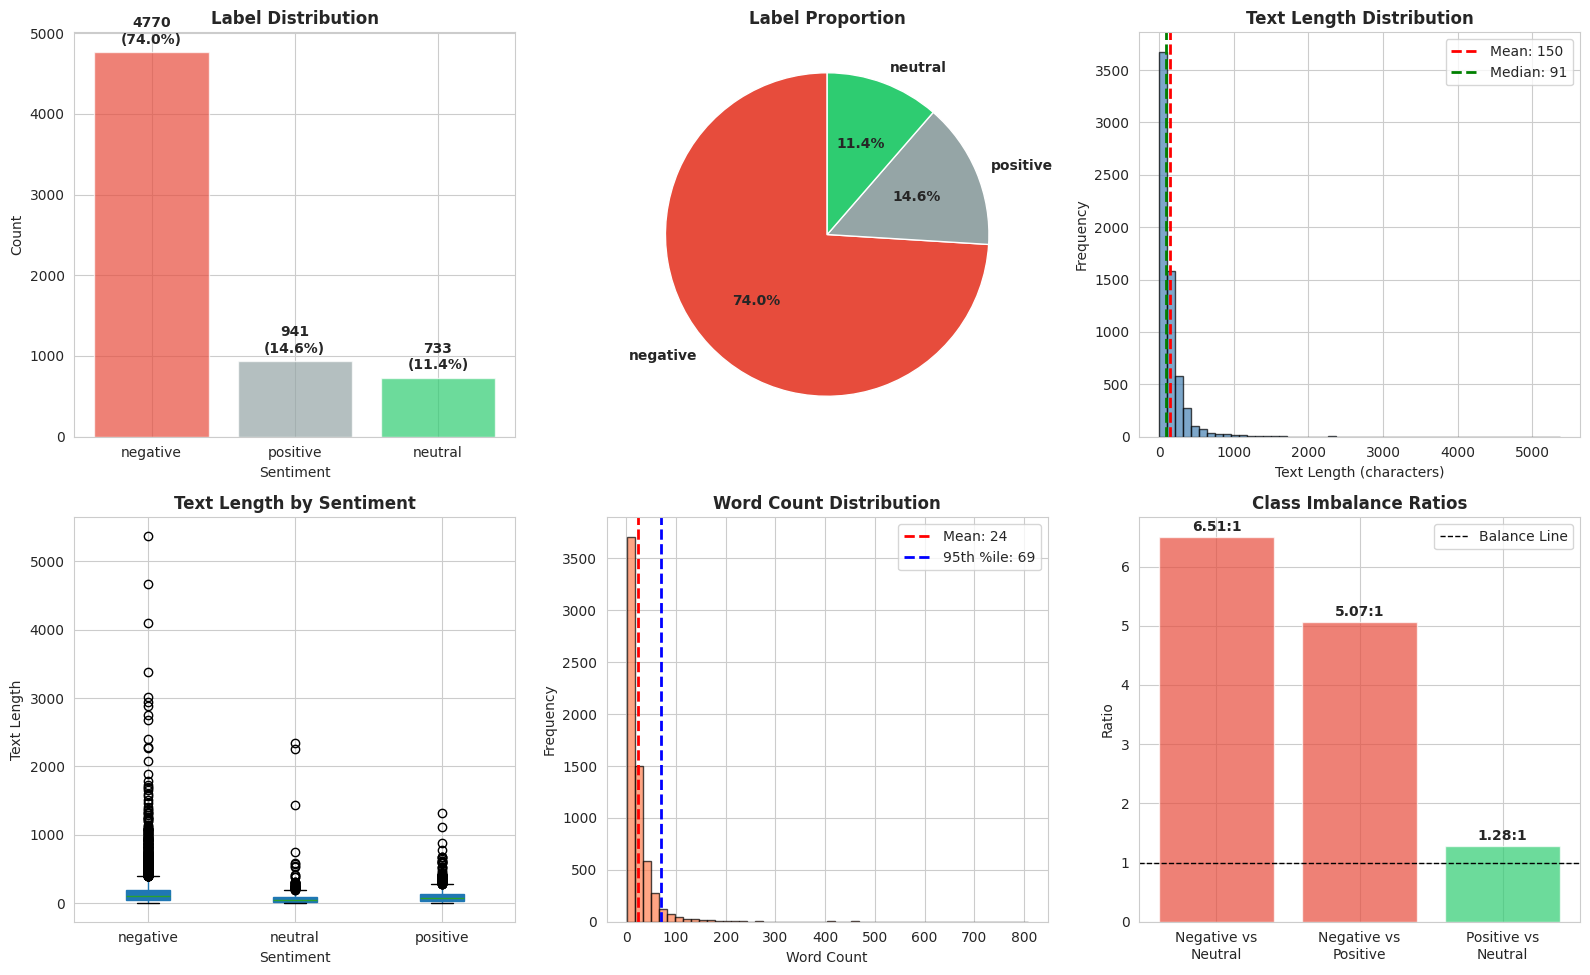

In [7]:
# VISUALIZATION

fig = plt.figure(figsize=(16, 10))

# Label Distribution (Bar)
ax1 = plt.subplot(2, 3, 1)
colors = ['#e74c3c', '#95a5a6', '#2ecc71']
bars = ax1.bar(label_counts.index, label_counts.values, color=colors, alpha=0.7)
ax1.set_title('Label Distribution', fontweight='bold', fontsize=12)
ax1.set_ylabel('Count')
ax1.set_xlabel('Sentiment')
for i, (bar, count) in enumerate(zip(bars, label_counts.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, count + 100,
             f'{count}\n({label_percentages.values[i]:.1f}%)',
             ha='center', fontweight='bold')

# Label Distribution (Pie)
ax2 = plt.subplot(2, 3, 2)
ax2.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontweight': 'bold'})
ax2.set_title('Label Proportion', fontweight='bold', fontsize=12)

# Text Length Distribution
ax3 = plt.subplot(2, 3, 3)
ax3.hist(df['text_length'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(df['text_length'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {df["text_length"].mean():.0f}')
ax3.axvline(df['text_length'].median(), color='green', linestyle='--',
            linewidth=2, label=f'Median: {df["text_length"].median():.0f}')
ax3.set_title('Text Length Distribution', fontweight='bold', fontsize=12)
ax3.set_xlabel('Text Length (characters)')
ax3.set_ylabel('Frequency')
ax3.legend()

# Text Length by Sentiment
ax4 = plt.subplot(2, 3, 4)
df.boxplot(column='text_length', by='label_sentimen', ax=ax4, patch_artist=True)
ax4.set_title('Text Length by Sentiment', fontweight='bold', fontsize=12)
ax4.set_xlabel('Sentiment')
ax4.set_ylabel('Text Length')
plt.suptitle('')

# Word Count Distribution
ax5 = plt.subplot(2, 3, 5)
ax5.hist(df['word_count'], bins=50, color='coral', alpha=0.7, edgecolor='black')
ax5.axvline(df['word_count'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {df["word_count"].mean():.0f}')
ax5.axvline(percentile_95, color='blue', linestyle='--',
            linewidth=2, label=f'95th %ile: {percentile_95}')
ax5.set_title('Word Count Distribution', fontweight='bold', fontsize=12)
ax5.set_xlabel('Word Count')
ax5.set_ylabel('Frequency')
ax5.legend()

# Imbalance Visualization
ax6 = plt.subplot(2, 3, 6)
imbalance_data = {
    'Negative vs\nNeutral': label_counts['negative'] / label_counts['neutral'],
    'Negative vs\nPositive': label_counts['negative'] / label_counts['positive'],
    'Positive vs\nNeutral': label_counts['positive'] / label_counts['neutral']
}
bars = ax6.bar(imbalance_data.keys(), imbalance_data.values(),
               color=['#e74c3c', '#e74c3c', '#2ecc71'], alpha=0.7)
ax6.axhline(y=1, color='black', linestyle='--', linewidth=1, label='Balance Line')
ax6.set_title('Class Imbalance Ratios', fontweight='bold', fontsize=12)
ax6.set_ylabel('Ratio')
ax6.legend()
for bar, ratio in zip(bars, imbalance_data.values()):
    ax6.text(bar.get_x() + bar.get_width()/2, ratio + 0.1,
             f'{ratio:.2f}:1', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('eda_visualization.png', dpi=300, bbox_inches='tight')
print("\n EDA visualization saved as 'eda_visualization.png'")
plt.show()

In [8]:
# LABEL ENCODING & CLASS WEIGHTS

# Label mapping
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_numeric'] = df['label_sentimen'].map(label_mapping)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label_numeric']),
    y=df['label_numeric']
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("\n Label Mapping:")
print("-" * 50)
for label, idx in label_mapping.items():
    print(f"  {label:10s} → {idx}")

print("\n Class Weights (for handling imbalance):")
print("-" * 50)
for label, weight in class_weight_dict.items():
    label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label)]
    print(f"{label_name:10s} (class {label}): {weight:.4f}")

print("\n Interpretation:")
print("-" * 50)
print("Higher weights for minority classes (Neutral, Positive)")
print("Lower weight for majority class (Negative)")
print("These weights will be used in model training")


 Label Mapping:
--------------------------------------------------
  negative   → 0
  neutral    → 1
  positive   → 2

 Class Weights (for handling imbalance):
--------------------------------------------------
negative   (class 0): 0.4503
neutral    (class 1): 2.9304
positive   (class 2): 2.2827

 Interpretation:
--------------------------------------------------
Higher weights for minority classes (Neutral, Positive)
Lower weight for majority class (Negative)
These weights will be used in model training



 Split Results:
--------------------------------------------------
Training set:    4510 samples (70.0%)
Validation set:   967 samples (15.0%)
Test set:         967 samples (15.0%)
Total:           6444 samples

 Distribution Verification:
--------------------------------------------------

Original:
  negative  : 4770 (74.02%)
  neutral   :  733 (11.37%)
  positive  :  941 (14.60%)

Train:
  negative  : 3338 (74.01%)
  neutral   :  513 (11.37%)
  positive  :  659 (14.61%)

Validation:
  negative  :  716 (74.04%)
  neutral   :  110 (11.38%)
  positive  :  141 (14.58%)

Test:
  negative  :  716 (74.04%)
  neutral   :  110 (11.38%)
  positive  :  141 (14.58%)

Split distribution saved as 'data_split_distribution.png'


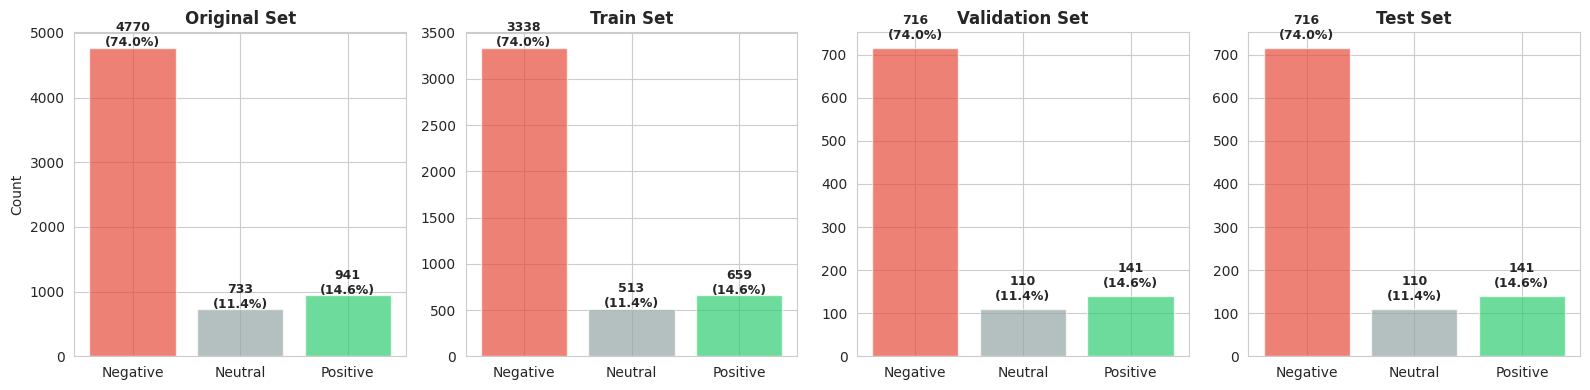

In [9]:
# DATA SPLITTING (STRATIFIED)

X = df['clean_text'].values
y = df['label_numeric'].values

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Second split: 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"\n Split Results:")
print("-" * 50)
print(f"Training set:   {len(X_train):5d} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val):5d} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set:       {len(X_test):5d} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"Total:          {len(X):5d} samples")

# Verify stratification
print(f"\n Distribution Verification:")
print("-" * 50)

splits = {
    'Original': y,
    'Train': y_train,
    'Validation': y_val,
    'Test': y_test
}

for split_name, split_data in splits.items():
    print(f"\n{split_name}:")
    counter = Counter(split_data)
    for label_id in sorted(counter.keys()):
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label_id)]
        count = counter[label_id]
        pct = count / len(split_data) * 100
        print(f"  {label_name:10s}: {count:4d} ({pct:5.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#e74c3c', '#95a5a6', '#2ecc71']

for idx, (split_name, split_data) in enumerate(splits.items()):
    counter = Counter(split_data)
    counts = [counter[i] for i in range(3)]

    axes[idx].bar(label_names, counts, color=colors, alpha=0.7)
    axes[idx].set_title(f'{split_name} Set', fontweight='bold')
    axes[idx].set_ylabel('Count' if idx == 0 else '')

    for i, v in enumerate(counts):
        pct = v / len(split_data) * 100
        axes[idx].text(i, v + 20, f'{v}\n({pct:.1f}%)',
                      ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('data_split_distribution.png', dpi=300, bbox_inches='tight')
print("\nSplit distribution saved as 'data_split_distribution.png'")
plt.show()

In [10]:
# SAVE PROCESSED DATA

# Create directory
os.makedirs('processed_data', exist_ok=True)

# Save splits
np.save('processed_data/X_train.npy', X_train)
np.save('processed_data/X_val.npy', X_val)
np.save('processed_data/X_test.npy', X_test)
np.save('processed_data/y_train.npy', y_train)
np.save('processed_data/y_val.npy', y_val)
np.save('processed_data/y_test.npy', y_test)

# Save metadata
metadata = {
    'label_mapping': label_mapping,
    'class_weights': class_weight_dict,
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'total_size': len(X),
    'imbalance_ratio': imbalance_ratio,
    'label_distribution': dict(label_counts),
    'recommended_max_len_bilstm': percentile_95,
    'recommended_max_len_bert': 128
}

with open('processed_data/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

# Save preprocessing config
preprocessing_config = {
    'preprocess_function': preprocess_text,
    'text_stats': {
        'mean_length': df['text_length'].mean(),
        'median_length': df['text_length'].median(),
        'mean_word_count': df['word_count'].mean(),
        'median_word_count': df['word_count'].median(),
        'percentile_95_words': percentile_95,
        'percentile_99_words': percentile_99
    }
}

with open('processed_data/preprocessing_config.pkl', 'wb') as f:
    pickle.dump(preprocessing_config, f)

print("\nData saved successfully")
print("\nSaved files:")
print("  - processed_data/X_train.npy")
print("  - processed_data/X_val.npy")
print("  - processed_data/X_test.npy")
print("  - processed_data/y_train.npy")
print("  - processed_data/y_val.npy")
print("  - processed_data/y_test.npy")
print("  - processed_data/metadata.pkl")
print("  - processed_data/preprocessing_config.pkl")


Data saved successfully

Saved files:
  - processed_data/X_train.npy
  - processed_data/X_val.npy
  - processed_data/X_test.npy
  - processed_data/y_train.npy
  - processed_data/y_val.npy
  - processed_data/y_test.npy
  - processed_data/metadata.pkl
  - processed_data/preprocessing_config.pkl


In [11]:
# SUMMARY
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

print("\nDATASET SUMMARY:")
print("-" * 50)
print(f"Total Samples: {len(df)}")
print(f"Features: clean_text")
print(f"Classes: 3 (Negative, Neutral, Positive)")
print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Average Text Length: {df['text_length'].mean():.0f} characters")
print(f"Average Word Count: {df['word_count'].mean():.0f} words")


SUMMARY

DATASET SUMMARY:
--------------------------------------------------
Total Samples: 6444
Features: clean_text
Classes: 3 (Negative, Neutral, Positive)
Imbalance Ratio: 6.51:1
Average Text Length: 150 characters
Average Word Count: 24 words
